# Beiwe Sample Dataset Accelerometer EDA Pt. 3

Test helper functions to load, summarize, and visualize multiple hours' worth of accelerometer data 


In [7]:
%load_ext autoreload
%autoreload 2 


import pyarrow.parquet as pq
import pyarrow as pa
from datetime import timedelta
from collections import defaultdict
from pathlib import Path
import os
import sys
sys.path.append('../src') 
from helper import summarize_period, plot_data_availability, plot_sampling_time, plot_mean_magnitude

import re
import random
import math
import warnings
import logging
from typing import List, Dict, Tuple, Optional
import numpy as np
import pandas as pd
import pytz
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
BASE_PATH = 'sample_imputation/data/raw/'
SUBJECT_ID = '3si9xdvl'
START_DATE = '2022-03-26'
END_DATE = '2022-03-26'

In [9]:
# Use Path for reliable path handling
BASE_PATH = Path('../data/raw/')  # Adjust relative to notebook location
SUBJECT_ID = '3si9xdvl'
START_DATE = '2022-03-26'
END_DATE = '2022-03-26'

# Test with enhanced error handling and data validation
try:
    # Verify path exists
    if not BASE_PATH.exists():
        raise FileNotFoundError(f"Base path does not exist: {BASE_PATH}")
        
    # Get data summary
    summary_1day = summarize_period(
        subject_id=SUBJECT_ID,
        start_date=START_DATE,
        end_date=END_DATE,
        base_path=str(BASE_PATH)  # Convert Path to string
    )
    
    # Check if we got any data
    if summary_1day is None or summary_1day.empty:
        print(f"No data found for subject {SUBJECT_ID} between {START_DATE} and {END_DATE}")
    else:
        # Process data if we have it
        if 'date' in summary_1day.columns and 'hour' in summary_1day.columns:
            summary_1day['datetime_utc'] = pd.to_datetime(
                summary_1day['date'] + ' ' + summary_1day['hour'].astype(str).str.zfill(2) + ':00'
            )
            
            # Sort and display results
            summary_1day = summary_1day.sort_values('datetime_utc').reset_index(drop=True)
            
            print(f"\nLoaded {len(summary_1day)} hours")
            print("\nColumns available:", summary_1day.columns.tolist())
            print("\nFirst few rows:")
            print(summary_1day.head())
        else:
            print("Required columns 'date' and 'hour' not found in summary data")
            print("Available columns:", summary_1day.columns.tolist())
    
except Exception as e:
    print(f"Error processing data: {str(e)}")
    import traceback
    print("\nFull error traceback:")
    print(traceback.format_exc())

Summarizing data for 3si9xdvl from 2022-03-26 to 2022-03-26...

2022-03-26:
OK: Hour 00: 602 rows
MISSING: Hour 01: missing
MISSING: Hour 02: missing
MISSING: Hour 03: missing
OK: Hour 04: 8,620 rows
OK: Hour 05: 11,438 rows
OK: Hour 06: 18,081 rows
OK: Hour 07: 18,100 rows
OK: Hour 08: 18,098 rows
OK: Hour 09: 18,090 rows
OK: Hour 10: 18,088 rows
OK: Hour 11: 18,098 rows
OK: Hour 12: 18,098 rows
OK: Hour 13: 18,090 rows
OK: Hour 14: 17,487 rows
MISSING: Hour 15: missing
OK: Hour 16: 9,049 rows
OK: Hour 17: 18,086 rows
OK: Hour 18: 18,085 rows
OK: Hour 19: 18,081 rows
OK: Hour 20: 18,075 rows
OK: Hour 21: 18,065 rows
OK: Hour 22: 12,650 rows
OK: Hour 23: 11,455 rows

Processed 20 hours across 1 days
Duty cycle mode: 0.51

Loaded 20 hours

Columns available: ['n_rows', 'start_time', 'end_time', 'duration_min', 'sampling_min', 'duty_cycle', 'n_bursts', 'mean_magnitude', 'subject_id', 'date', 'hour', 'std_magnitude', 'datetime_utc', 'local_time', 'day_of_wk', 'weekend', 'duty_cycle_mode',

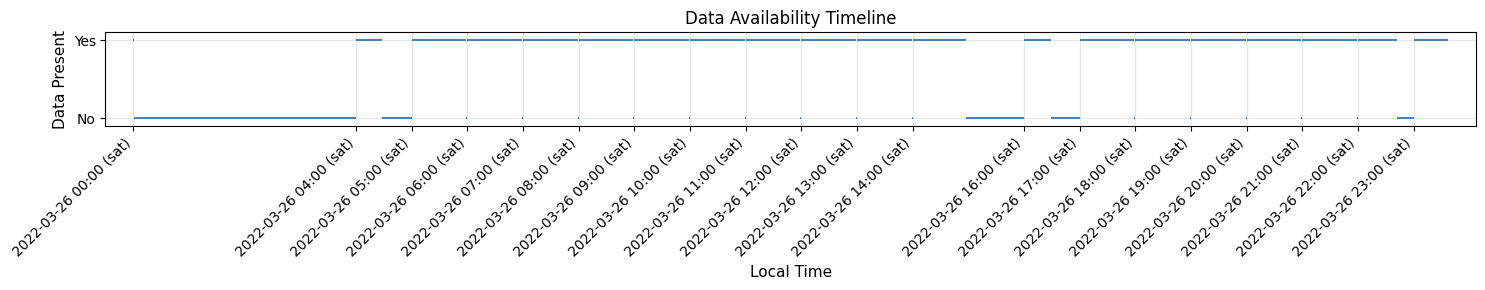

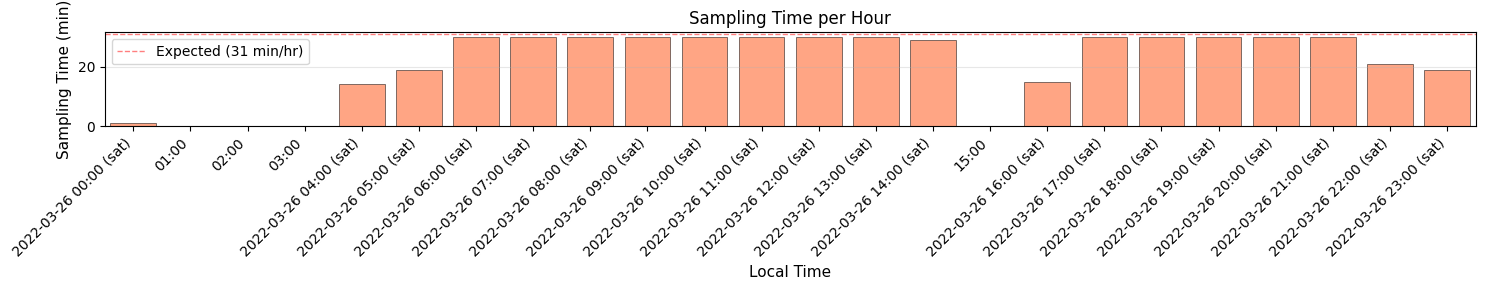

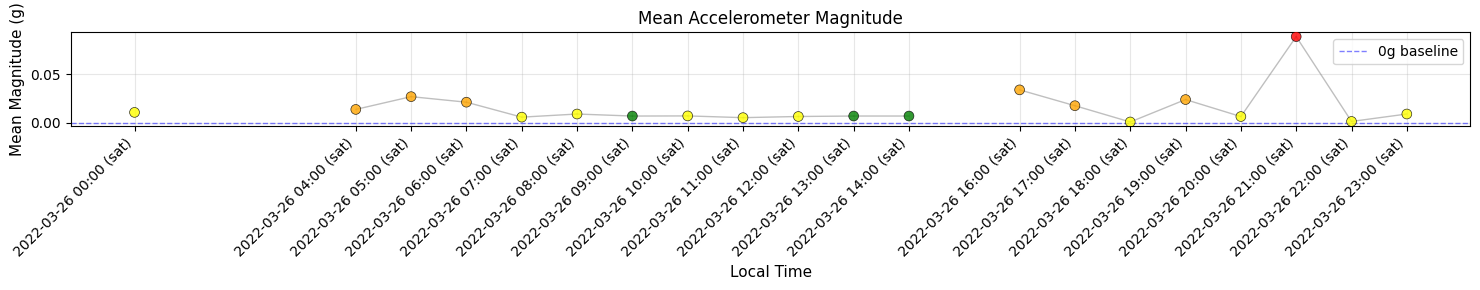

In [15]:
# Create a new cell after the data loading code
# Plot the data using helper functions
if 'summary_1day' in locals() and not summary_1day.empty:
    # Create individual plots instead of subplots
    # Each helper function creates its own figure
    
    # Plot 1: Data availability
    plot_data_availability(summary_1day, time_unit='hour', figsize=(15,3))
    plt.title('Data Availability Timeline')
    plt.show()
    
    # Plot 2: Sampling time 
    plot_sampling_time(summary_1day, time_unit='hour', figsize=(15,3))
    plt.title('Sampling Time per Hour')
    plt.show()
    
    # Plot 3: Mean magnitude
    plot_mean_magnitude(summary_1day, time_unit='hour', figsize=(15,3))
    plt.title('Mean Accelerometer Magnitude')
    plt.show()
    
else:
    print("No data available to plot")

In [16]:
summary_3days = summarize_period(
    subject_id=SUBJECT_ID,
    start_date='2022-03-26',
    end_date='2022-03-28',
    base_path=BASE_PATH
)

print(f"Loaded {len(summary_3days)} hours across 3 days")

Summarizing data for 3si9xdvl from 2022-03-26 to 2022-03-28...

2022-03-26:
OK: Hour 00: 602 rows
MISSING: Hour 01: missing
MISSING: Hour 02: missing
MISSING: Hour 03: missing
OK: Hour 04: 8,620 rows
OK: Hour 05: 11,438 rows
OK: Hour 06: 18,081 rows
OK: Hour 07: 18,100 rows
OK: Hour 08: 18,098 rows
OK: Hour 09: 18,090 rows
OK: Hour 10: 18,088 rows
OK: Hour 11: 18,098 rows
OK: Hour 12: 18,098 rows
OK: Hour 13: 18,090 rows
OK: Hour 14: 17,487 rows
MISSING: Hour 15: missing
OK: Hour 16: 9,049 rows
OK: Hour 17: 18,086 rows
OK: Hour 18: 18,085 rows
OK: Hour 19: 18,081 rows
OK: Hour 20: 18,075 rows
OK: Hour 21: 18,065 rows
OK: Hour 22: 12,650 rows
OK: Hour 23: 11,455 rows

2022-03-27:
OK: Hour 00: 18,085 rows
OK: Hour 01: 18,078 rows
OK: Hour 02: 1,344 rows
OK: Hour 03: 16,273 rows
OK: Hour 04: 3,911 rows
OK: Hour 05: 12,054 rows
MISSING: Hour 06: missing
MISSING: Hour 07: missing
OK: Hour 08: 4,435 rows
OK: Hour 09: 18,047 rows
OK: Hour 10: 18,066 rows
OK: Hour 11: 18,073 rows
OK: Hour 12: 

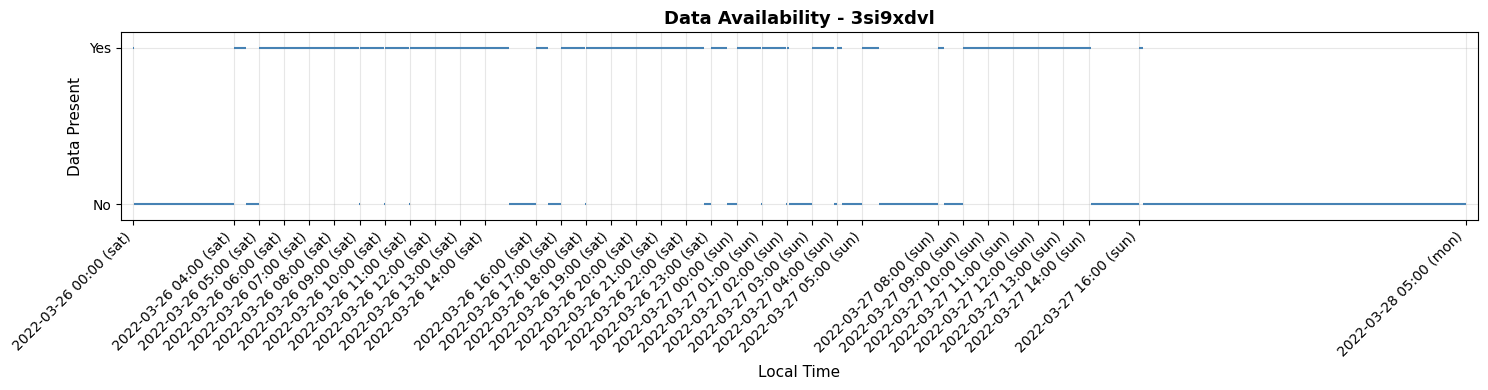

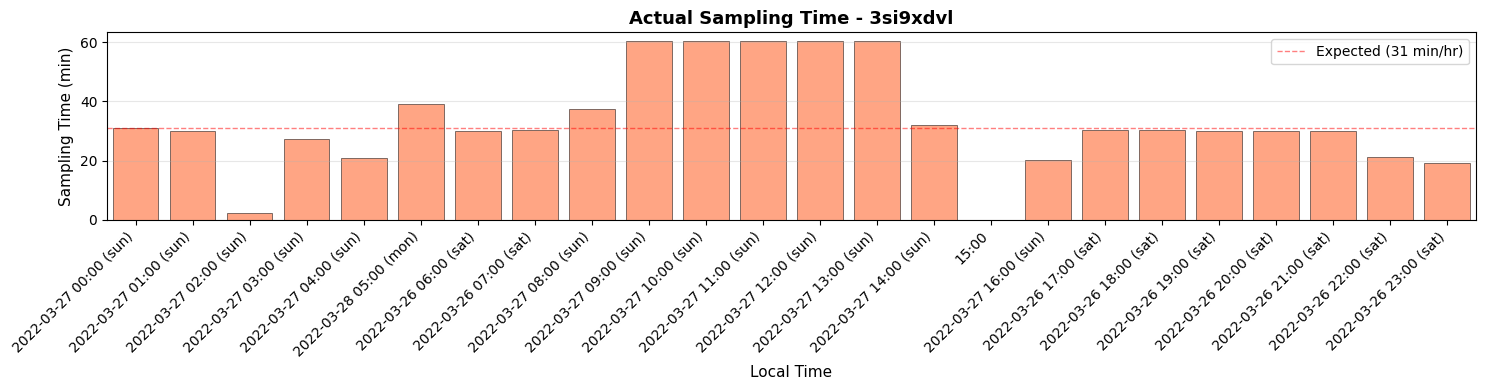

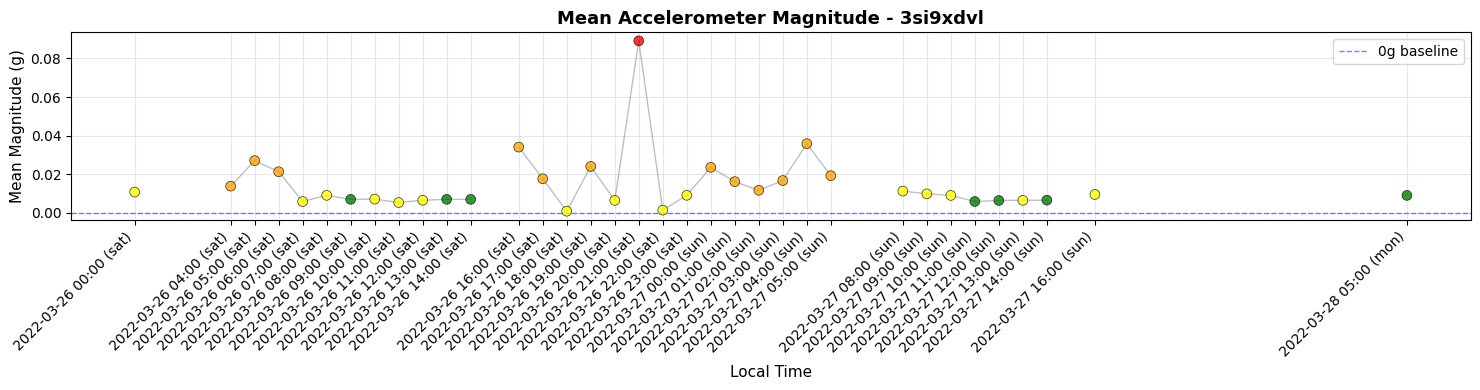

In [17]:
plot_data_availability(summary_3days, time_unit='hour')
plt.show()

plot_sampling_time(summary_3days, time_unit='hour')
plt.show()

plot_mean_magnitude(summary_3days, time_unit='hour')
plt.show()